# Lesson1 手書き文字認識をしよう（ニューラルネットワーク入門）

## 目次

- Section1 解説
  - 1.1 Keras実装プロセス
  - 1.2 各モデルLayer
  - 1.3 損失関数
  - 1.4 評価関数
  - 1.5 Functional API
  - 1.6 確認問題
- Section2 実装①
  - 2.1 MNISTによるMLPの復習
- Section3 テクニック・発展内容
  - 3.1 前処理
  - 3.2 勾配に関するテクニック
    - 3.2.1 最適化アルゴリズム (optimizer)
    - 3.2.2 活性化関数 (activation)
    - 3.2.3 初期化 (initializer)
  - 3.3 過学習に関するテクニック
    - 3.3.1 正則化 (regularization)
    - 3.3.2 早期終了 (early stopping)
    - 3.3.3 ドロップアウト (dropout)
  - 3.4 確認問題
- Section4 実装②
  - 4.1 Fashion MNIST
  - 4.2 実装

## Section1 解説

### 1.1 Keras実装プロセス

今回は早速KerasでMLPの実装方法を見ていきたいと思います。

まず、Kerasの雰囲気を感じ取ってもらうため、Kerasで機械学習を行う際に、

1. いったいどういった手順を踏むか
2. コードはどう書くのか

をざっくりと見ていきたいと思います。

題材としては、手書き数字画像を入力データ、対応する数字の値を出力データとする教師あり学習（分類）です。

参考：https://keras.io/ja/

### 1.1.0 データの用意
まず機械学習を適用するデータを用意しなければ始まりません。

ここでは、機械学習で頻繁に用いられる、MNISTの手書き数字データセットを用います。

データセットの中身は、

* x:手書き数字画像(28×28)
* y:正解のラベル（xの画像が表す数字）

となっていますが、

* (x_train, y_train):モデルの学習用
* (x_test, y_test):モデルの評価用

と区別してあります。

機械学習では汎化性能の向上が至上命題なので、学習用のデータだけでなく評価用のデータが必要になることは前回触れました。

MNISTのデータセットも、全てのデータを使用するのではなく、学習用と評価用に予め分割してあるわけです。

（分割は事前に行っておく必要があります。評価用のデータまで使用して学習を行うのは、カンニングと変わらなくなってしまいます。）

なお、KerasではこのMNISTのデータセットに限らず、機械学習で頻繁に用いられるデータセットがいくつも用意されており、性能評価を手軽に行えます。

keras.datasets以下からimportすることで使用できますので、ぜひ使っていきましょう。

Kerasから直接使用できるデータセットの一覧はこちら( https://keras.io/ja/datasets/ )です。

In [1]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

11493376/11490434 [==============================] - 1s 0us/step


今回扱うMNISTの手書き数字のデータを下記で表示してみましょう。

表示する際には、matplotlibを用います。これはPythonでグラフの表示をする際に標準的に用いられるライブラリです。

中でもpyplotは最もよく使用されるモジュールで、標準的な描画処理の多くに対応しています。

ここでは詳しくは説明しませんが、公式のマニュアルでpyplotに含まれる関数に目を通しておくことをお勧めします。

参考：https://matplotlib.org/api/pyplot_api.html

なお、jupyer notebook上でmatplotlibの結果を表示するには、`%matplotlib inline`を冒頭で宣言する必要があります。

（ちなみに、このような`%`あるいは`%%`から始まるjupyter notebookに対するコマンドはマジックコマンドと呼ばれ、他にも様々なものが存在します。）

また、MNISTの画像には、それぞれに対して画像が示す数字が正解のラベルとして与えられています。

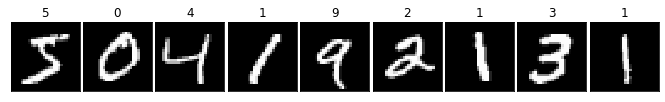

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

これから、このMNISTの各画像が0～9のどの数字であるか分類する事を考えていきます。

問題としては、いわゆる10クラス分類の問題です。（分類先のことを**クラス**と呼びます）

さて、ここで特に分類タスクの際に気をつけたいことがあります。

分類タスクの時の出力データはラベルですが、ラベルは数字としての大小には意味がないということです。

というのも、グループの名前として数字を割り振っているだけであるためです。こうした数字を**名義尺度**と呼びます。

機械学習のアルゴリズムでは数字の大小に意味があるものとして扱ってしまうため、名義尺度をうまく変換しなければなりません。

この名義尺度を変換する表現として使用されるのが、**one-hot表現**と呼ばれるものです。

全体で3クラスあるときの各クラスの表現は次の通りです。

<ul>
    <li>1：$[1,0,0]$</li>
    <li>2：$[0,1,0]$</li>
    <li>3：$[0,0,1]$</li>
</ul>

長さ3のベクトルを用いて、各クラスの対応する要素のみ1として表現するということです。

一般化すると、全体で$K$クラスある時、$k$番目のクラスに属するとき、

$$\underset{K}{\underbrace{[0,\cdots,0,\overset{k}{\check{1}},0,\cdots,0]}}$$

と表現するということです。

このone-hot表現への変換を行ってくれる関数がKerasにはあります。

keras.utils.to_categorical関数がその関数です。さっそくMNISTのデータセットにも適用してみましょう。

https://keras.io/ja/utils/#to_categorical

In [3]:
from tensorflow.keras.utils import to_categorical

# 入力画像を行列(28x28)からベクトル(長さ784)に変換
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 名義尺度の値をone-hot表現へ変換
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [6]:
y_train[0],y_train[1]

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

### 1.1.1 モデル構築

学習に使用するMLPのモデルを構築します。具体的には、どんなlayer（層）をどこに配置するか、また各layerのユニット数はいくつかを指定していきます。

このモデルを構築するための「容器」として機能するのが、keras.models.Sequentialクラスです。

この「容器」の中に、Sequential.add関数によってkeras.layersに定義されているlayerクラス（後で詳述）を積み重ねていくことでモデルの構築を行います。

layerをSequentialクラスに積み終えたら、最後にSequential.compile関数でモデルの学習処理について指定し、モデル構築は完了です。

compile関数では

* optimizer（最適化手法）
* loss（損失関数）
* metrics（評価関数（任意））

を指定することになります。（いずれも後で詳述）

https://keras.io/ja/models/sequential/

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# モデルの「容器」を作成
model = Sequential()

# 「容器」へ各layer（Dense, Activation）を積み重ねていく（追加した順に配置されるので注意）
# 最初のlayerはinput_shapeを指定して、入力するデータの次元を与える必要がある
model.add(Dense(units=256, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(units=100))
model.add(Activation('relu'))
model.add(Dense(units=10))
model.add(Activation('softmax'))

# モデルの学習方法について指定しておく
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


### 1.1.2 モデルの学習

1.2.1で構築したモデルで実際に学習を行うには、Sequential.fit関数を用います。この関数は固定長のバッチで学習を行います。

主な引数は次の通りです。

* x：学習に使用する入力データ
* y：学習に使用する出力データ
* batch_size：学習中のパラメータ更新を1回行うにあたって用いるサンプル数（ミニバッチのサイズ）
* epochs：学習のエポック数
* verbose：学習のログを出力するか（0:しない、1：バーで出力、2:エポックごとに出力）
* validation_split/validation_data：検証用に用いるデータの割合（0～１の実数）、または検証用データそのもの（いずれかのみ指定可能）
* shuffle：各エポックごとにデータをシャッフルするか
* callbacks：訓練中のモデルの挙動を監視できるcallback関数を指定できます

In [8]:
model.fit(x_train, y_train,
          batch_size=1000, epochs=10, verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 1s 13us/sample - loss: 6.7070 - acc: 0.5720 - val_loss: 3.2233 - val_acc: 0.7885
Epoch 2/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.9359 - acc: 0.8086 - val_loss: 2.6558 - val_acc: 0.8262
Epoch 3/10
60000/60000 [==============================] - 1s 12us/sample - loss: 2.5579 - acc: 0.8326 - val_loss: 2.5118 - val_acc: 0.8368
Epoch 4/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3538 - acc: 0.8465 - val_loss: 2.3372 - val_acc: 0.8475
Epoch 5/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.2238 - acc: 0.8556 - val_loss: 2.2211 - val_acc: 0.8546
Epoch 6/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.1376 - acc: 0.8613 - val_loss: 2.1805 - val_acc: 0.8583
Epoch 7/10
60000/60000 [==============================] - 1s 11us/sa

モデルの評価を行うには、Sequential.evaluate関数を用います。この関数は固定長のバッチごとに損失関数値または評価関数値を出力します。

主な引数は次の通りです。

* x：評価に使用する入力データ
* y：評価に使用する出力データ
* batch_size：1回の評価を行うにあたって用いるサンプル数
* verbose：評価のログを出力するか（0:しない、1：する(デフォルト)）

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.0688752796173095
Test accuracy: 0.8654


### 1.1.3 モデルによる予測

1.2.2で学習させたモデルによって予測を行ってみましょう。Sequential.predict関数によって予測が行えます。

主な引数は次の通りです。

* x：予測に使用する入力データ
* batch_size：まとめて1度に予測を行うサンプル数
* verbose：評価のログを出力するか（0:しない(デフォルト)、1：する）

In [10]:
classes = model.predict(x_test, batch_size=128)

In [11]:
classes

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 2.5351597e-21, ..., 3.0606768e-17,
        0.0000000e+00, 1.5602878e-37],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.9089887e-24, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

### 1.1.4 モデルの可視化

1.1.1で作成したモデルは次のようにしてグラフで表現することができます。

https://keras.io/ja/visualization/

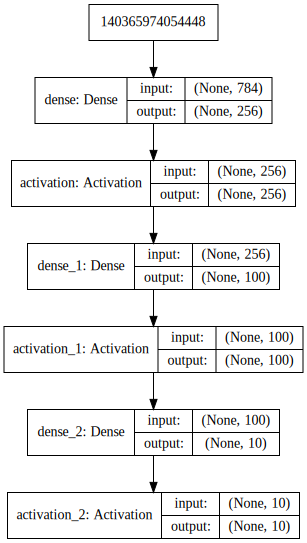

In [12]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### 1.2 各モデルLayer

ここからは、layerクラスについて詳しくみていきましょう。

MLPで中心的な存在である、層を表すクラスがlayerクラスです。

layerには様々な種類があり、そのそれぞれが独自の機能を持っているので、役割をある程度覚えておきましょう。

今回は最もオーソドックスなlayerとして、keras.layers.core以下に定義されている中で使用頻度の高いものを紹介します。

https://keras.io/ja/layers/about-keras-layers/

https://keras.io/ja/layers/core/

### 1.2.1 Dense

一般的な全結合層を表すレイヤーです。つまり、入力$u\in\mathbb{R}^D$に対して、

$$v = \sigma(Wu+b) \in\mathbb{R}^{D'}$$

を出力します。

なお、$W\in\mathbb{R}^{D' \times D}$は重み行列を表し、$b\in\mathbb{R}^{D'}$はバイアスを表しています。

重み行列とバイアスは学習によって値が決まることに注意しましょう。

また$\sigma(x):\mathbb{R}^{D'}\to\mathbb{R}^{D'}$は**活性化関数**と呼ばれるもので、任意に指定可能です。

（実際には最後の出力層の活性化関数については問題の特性から決まることも多いです）

一般に活性化関数には非線形関数を指定することで、MLPの性能を向上させます。

```py
keras.layers.core.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
                        kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                        kernel_constraint=None, bias_constraint=None)
```

主な引数は

* units: 出力ユニット数($N$)
* activation: 出力ユニットに適用する活性化関数、Activationレイヤーの説明を参照
* use_bias: バイアス$b$を使用するか
* kernel_initializer: 重み行列$W$の初期化方法（initializerについては3章で扱います）
* bias_initializer: バイアス$b$の初期化方法（initializerについては3章で扱います）

です。またshapeの入出力での変化は

<ol>(batch_size, ..., input_dim) --> (batch_size, ..., units)</ol>

のとおり、一番深いネストの次元がinput_dimからunitsに変わるだけです。

1.1.1のモデルの構築で出てきた例を以下に再掲します。

```py
from keras.layers import Dense, Activation

model.add(Dense(units=256, input_shape=(784,))) # 次元の変化: 784 -> 256
model.add(Activation('relu'))
model.add(Dense(units=100)) # 次元の変化: 256 -> 100
model.add(Activation('relu'))
model.add(Dense(units=10)) # 次元の変化: 100 -> 10
model.add(Activation('softmax'))
```

### 1.2.2 Activation

入力に対して活性化関数を適用したものを出力します。

```py
keras.layers.core.Activation(activation)
```

引数は

* activation: 適用する活性化関数

のみです。（入力と出力でshapeは変わりません）

活性化関数として使用できる関数の一覧はこちら( https://keras.io/ja/activations/ )です。

よく使用されるものを以下に示します。

* sigmoid: $f(x)=\dfrac{1}{1+e^{-x}}$
* ReLU: $f(x)=\max(0,x)$
* tanh: $f(x)=\tanh(x)=\dfrac{e^x-e^{-x}}{e^x+e^{-x}}$
* softmax: $f(x)=\dfrac{\exp(x_d)}{\sum_{d'} \exp(x_{d'})} \quad (x\in\mathbb{R}^D,\ d=1,2,\ldots,D)$

特にsoftmax関数は出力が規格化されているので、確率として解釈できるため多クラス分類タスクの出力層に使用されることが多いです。

（2クラス分類であればsigmoid関数を出力層に使用することも多いです）

ここで、活性化関数をプロットしてみましょう。(多変数関数のsoftmaxを除く)

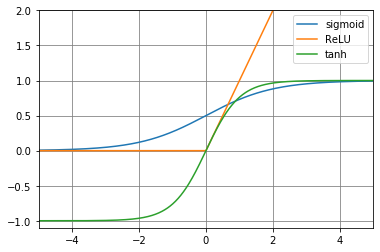

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1+np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

fig = plt.figure()
x = np.linspace(-10, 10, 1000)

ax = fig.add_subplot(111)
ax.plot(x, sigmoid(x), label='sigmoid')
ax.plot(x, relu(x), label='ReLU')
ax.plot(x, tanh(x), label='tanh')

plt.legend()
plt.xlim(-5, 5)
plt.ylim(-1.1, 2)
plt.grid(which='major',color='gray',linestyle='-')
plt.show()

1.1.1のモデルの構築で出てきた例を以下に再掲します。

```py
from keras.layers import Dense, Activation

model.add(Dense(units=256, input_shape=(784,)))
model.add(Activation('relu')) # 活性化関数として relu を選択
model.add(Dense(units=100))
model.add(Activation('relu')) # 活性化関数として relu を選択
model.add(Dense(units=10))
model.add(Activation('softmax')) # 活性化関数として softmax を選択
```

なお、活性化関数はDenseレイヤーなどで直接指定することも可能で、実際に以下のコードは上記と同じ結果になります。

```py
from keras.layers import Dense, Activation

model.add(Dense(256, input_shape=(784,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
```

### 1.2.3 Flatten

入力をフラット化します。つまり、リストの入れ子になっているデータを1つのリストに展開します。

(Ex. [[1,2,3],[4,5,6],[7],[8,9]]->[1,2,3,4,5,6,7,8,9])

```py
keras.layers.core.Flatten()
```

例は次の通りです。（出力shapeはbatch_sizeを除く入力shapeの積）

```py
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(3, 32, 32))) # 次元の変化: (3, 32, 32) -> (64, 32, 32)
# Conv2Dは未修ですが、ここではその機能は関係ないので気にしなくて結構です

model.add(Flatten()) # 次元の変化: (64, 32, 32) -> (65536,) (65536 = 64*32*32)
```

### 1.2.4 Reshape

入力を指定のshapeに変換して出力します。

```
keras.layers.core.Reshape(target_shape)
```

引数は
* target_shape: 変換先のshapeを表す整数のタプル、ただしサンプルの次元（バッチサイズ）を含まない

例は次の通りです。

```py
model = Sequential()
model.add(Reshape((3, 4), input_shape=(12,))) # 次元の変化: (12,) -> (3, 4)

model.add(Reshape((6, 2))) # 次元の変化: (3, 4) -> (6, 2)

# `-1`をしていすると、その次元については推定してくれます(6/2=3)
model.add(Reshape((-1, 2, 2))) # 次元の変化: (6, 2) -> (?, 2, 2)=(3, 2, 2)
```

### 1.2.5 Permute

入力の次元を入れ替えます。

```py
keras.layers.core.Permute(dims)
```

引数は

* dims: 次元の入れ替え方を指定する整数のタプル、サンプルの次元はふくまない1から始まるindexで指定

です。（入力と出力でshapeは変わりません）

例は次の通りです。

```py
model = Sequential()
model.add(Permute((2, 1), input_shape=(10, 64))) # 次元の変化: (10, 64) -> (64, 10)
```

### 1.2.6 RepeatVector

入力を指定回数繰り返します。

```py
keras.layers.core.RepeatVector(n)
```

引数は

* n: 入力の複製回数

です。またshapeの入出力での変化は

<ol>(num_samples, features) --> (num_samples, n, features)</ol>

であり、入力には2階のテンソルのみを受け付けます。

### 1.3 損失関数

モデルの学習にあたっては、損失関数の最小化を行うわけでした。そこで、続いて損失関数についてみていきます。

https://keras.io/ja/losses/

kerasではモデルをコンパイルする際に損失関数を設定します。

損失関数の選択においては、出力値が連続な場合と離散な場合で大きく異なってきます。

#### 連続値のとき

 主に使用されるのは**平均二乗誤差**です。これは各ミニバッチのデータ数を$N$として、

 $$E=\dfrac{1}{N}\sum_{n=1}^{N}(y_n-t_n)^2$$

 として表されます。(なお、$y_n, t_n$はそれぞれ入力$x_n$に対するモデルの出力値(y_pred)と出力データ(y_true)を表す)

 この平均二乗誤差を使用する場合、compile関数の引数として`loss='mean_squared_error'`を指定します。


#### 離散値のとき

主に使用されるのは、**（多クラス）交差エントロピー**です。2クラス分類の場合は交差エントロピーとして

$$E=-\dfrac{1}{N}\sum_{n=1}^N \left[t_n \ln y_n + (1-t_n) \ln (1-y_n) \right]$$

を使用し、多クラス分類（Kクラス）の場合は多クラス交差エントロピーとして

$$E=-\dfrac{1}{N}\sum_{n=1}^N \sum_{k=1}^K t_{nk} \ln y_{nk}$$

を用います。それぞれcompile関数の引数として`loss='binary_crossentropy'`、`loss='categorical_crossentropy'`を指定することで使用できます。
    

今回利用したMNISTは0~9の離散値であるため、以下のように多クラス交差エントロピーを利用しています。

```py
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
```
 

### 1.4 評価関数

評価関数(metric)はモデルの出力の良し悪しを評価します。

損失関数もモデルの良し悪しの指標となるという点では同じですが、損失関数は最適化計算をとおして学習に直接的に影響するのに対して、評価関数は学習には使用されず、あくまでその時点でのモデルの評価指標を出力するのみであるという違いがあります。

つまり、compile関数で指定すると、訓練やテストの際に参考情報として評価関数の値が返り値として受け取れるというだけです。

評価関数として使用することが多いのは**accuracy(正解率)**です。（正解率＝全体のデータに対して予測値が答えと一致した割合）

これはcompile関数の引数として、`metrics=['acc']`を指定することで使用できます。（リストに他の損失関数を含めれば、それらも同時に評価されます）

https://keras.io/ja/metrics/

### 1.5 Functional API

ここまではkeras.models.Sequentialクラスを用いたモデル構築を説明しました。

Sequentialクラスを用いる場合はadd関数を使用して簡単にモデルを構築できますが、途中に分岐や合流があるような複雑なモデルは作成できません。

こうしたより複雑なモデルの構築には別の方法が用意されています。それが**Functional API**です。この特徴は

* **Inputレイヤー**から構築を始める
* 各レイヤーの返り値（テンソル）を次のレイヤーの入力として順々に構築していく
* **keras.models.Modelクラス**に入力と出力を指定することでインスタンス化

という点です。一度Modelクラスのインスタンスを作ってしまえば、後の学習等はSequentialクラスによる場合と同様です。

より詳しくは、実際にFunctional APIが必須になる第4回で扱いますが、すぐにFunctional APIの発展的な利用法をみたいという方は、

下記の公式HPのリンクにいくつか記載がありますので参考にしてみてください。

https://keras.io/ja/getting-started/functional-api-guide/

https://keras.io/ja/models/model/

### 1.6 確認問題

1. 学習データ以外の未知のデータに対するモデルの予測性能を何というか  
  ①神通力　②バイアス　③汎化性能　④共起性
2. データセット全体を一度に全て使用して学習する方法を何というか  
  ①転移学習　②ワンショット学習　③過学習　④バッチ学習　
3. 名義尺度のデータをバイナリベクトルによって表現したものを何というか  
  ①分散表現　②one-hot表現　③ビット表現　④ユニタリ表現
4. モデルの学習に当たって最小化するものは何か  
  ①精度　②損失関数　③スコア　④F値

回答
1. 汎化性能
2. バッチ学習
3. one-hot表現
4. 損失関数